In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import matplotlib
import scipy.optimize as opt
from sklearn.metrics import classification_report#这个包是评价报告

In [2]:
data = sio.loadmat('ex4data1.mat')
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'y': array([[10],
        [10],
        [10],
        ...,
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

In [3]:
def load_data(path,transpose=True):
    data = sio.loadmat(path)
    y = data.get('y')
    y = y.reshape(y.shape[0])
    
    x = data.get('X')
    #转置把图像放正，原数据图像是错误的方向
    if transpose:
        #对每个图片放正
        x = np.array([im.reshape((20,20)).T for im in x])
        #再展开
        x = np.array([im.reshape(400) for im in x])
    
    return x,y

In [4]:
x1,y1 = load_data('ex4data1.mat')

In [5]:
def plot_100_image(x):
    size = int(np.sqrt(x.shape[1])) #图片大小
    
    sample_idx = np.random.choice(np.arange(x.shape[0]), 100)  #随机选100个图片的索引
    sample_images = x[sample_idx, :] # 100*400

    fig, ax_array = plt.subplots(nrows=10, ncols=10, sharey=True, sharex=True, figsize=(8, 8))

    for r in range(10):
        for c in range(10):
            ax_array[r, c].matshow(sample_images[10 * r + c].reshape((size, size)),
                                   cmap=matplotlib.cm.binary)
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))  
            #绘图函数，画100张图片

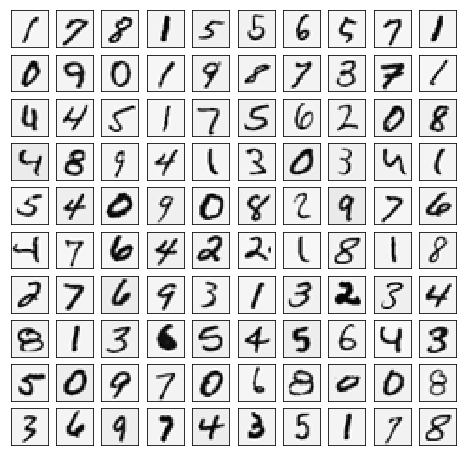

In [6]:
plot_100_image(x1)
plt.show()

### 对y进行one-hot编码

In [7]:
x = data['X']
y = data['y']
x = np.insert(x, 0, np.ones(x.shape[0]), axis=1)#增加全部为1的一列
x.shape,y.shape

((5000, 401), (5000, 1))

In [8]:
#使用scikitlearn内置函数
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)
y_onehot = encoder.fit_transform(y)
y_onehot.shape

(5000, 10)

In [9]:
y[0],y_onehot[0]

(array([10], dtype=uint8), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]))

我们要为此练习构建的神经网络具有与我们的实例数据（400 +偏置单元）大小匹配的输入层，25个单位的隐藏层（带有偏置单元的26个），以及一个输出层， 10个单位对应我们的一个one-hot编码类标签。 有关网络架构的更多详细信息和图像，请参阅“练习”文件夹中的PDF。

我们需要实现的第一件是评估一组给定的网络参数的损失的代价函数。 源函数在练习文本中（看起来很吓人）。 以下是代价函数的代码。

# sigmoid 函数
g 代表一个常用的逻辑函数（logistic function）为S形函数（Sigmoid function），公式为： \\[g\left( z \right)=\frac{1}{1+{{e}^{-z}}}\\] 
合起来，我们得到逻辑回归模型的假设函数： 
	\\[{{h}_{\theta }}\left( x \right)=\frac{1}{1+{{e}^{-{{\theta }^{T}}X}}}\\] 

In [10]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# 读取权重

In [11]:
def load_weight(path):
    data = sio.loadmat(path)
    return data['Theta1'], data['Theta2']

In [12]:
theta1, theta2 = load_weight('ex4weights.mat')
theta1.shape, theta2.shape

((25, 401), (10, 26))

In [13]:
theta1,theta2

(array([[-2.25623899e-02, -1.05624163e-08,  2.19414684e-09, ...,
         -1.30529929e-05, -5.04175101e-06,  2.80464449e-09],
        [-9.83811294e-02,  7.66168682e-09, -9.75873689e-09, ...,
         -5.60134007e-05,  2.00940969e-07,  3.54422854e-09],
        [ 1.16156052e-01, -8.77654466e-09,  8.16037764e-09, ...,
         -1.20951657e-04, -2.33669661e-06, -7.50668099e-09],
        ...,
        [-1.83220638e-01, -8.89272060e-09, -9.81968100e-09, ...,
          2.35311186e-05, -3.25484493e-06,  9.02499060e-09],
        [-7.02096331e-01,  3.05178374e-10,  2.56061008e-09, ...,
         -8.61759744e-04,  9.43449909e-05,  3.83761998e-09],
        [-3.50933229e-01,  8.85876862e-09, -6.57515140e-10, ...,
         -1.80365926e-06, -8.14464807e-06,  8.79454531e-09]]),
 array([[-0.76100352, -1.21244498, -0.10187131, -2.36850085, -1.05778129,
         -2.20823629,  0.56383834,  1.21105294,  2.21030997,  0.44456156,
         -1.18244872,  1.04289112, -1.60558756,  1.30419943,  1.37175046,
       

In [14]:
#序列化向量
def serialize(theta1,theta2):
    return np.concatenate((theta1.ravel(),theta2.ravel()))

In [15]:
theta = serialize(theta1,theta2)
theta.shape

(10285,)

In [16]:
def deserialize(seqtheta):
    #theta1(25,401) theta2(10,26)
    return seqtheta[:25 * 401].reshape(25,401),seqtheta[25 * 401:].reshape(10,26)

# 前向传播函数
> (400 + 1) -> (25 + 1) -> (10)

<img style="float: left;" src="images/neural_network.png">

In [17]:
# x (5000,400)
#theta(10285,)
# theta1(25,401)
# theta2 (10,26)
def forward_propagate(theta,x):
    m = x.shape[0]
    
    theta1,theta2 = deserialize(theta)
    #添加偏置
#     a1 = np.insert(x,0,values=np.ones(m),axis=1) #(5000,401)
    a1 = x
    z2 = a1 @ theta1.T  #(5000,401) @ (401,25) = (5000,25)
    a2 = sigmoid(z2) #(5000,25)
    
    a2 = np.insert(sigmoid(z2),0,values=np.ones(m),axis=1) #(5000,26)
    
    z3 = a2 @ theta2.T #(5000,26) @ (26,10) = (5000,10)
    h = sigmoid(z3) #(5000,10)
    return a1,z2,a2,z3,h

In [18]:
# _, _, _, _, h = forward_propagate(theta,x)
# h.shape

## 代价函数
<img style="float: left;" src="images/cost.png">

In [19]:
def cost_function(theta,x,y):
    m = x.shape[0]
        
    a1, z2, a2, z3, h = forward_propagate(theta,x)
    
#     j = 0
#     for i in range(m):
#         first_term = np.multiply(-y[i,:],np.log(h[i,:]))
#         second_term = np.multiply((1 - y[i,:]),np.log(1 - h[i,:]))
#         j += np.sum(first_term - second_term)
    # 直接向量化运算    
    first_term = -np.multiply(y,np.log(h))
    second_term = np.multiply((1 - y),np.log(1 - h))
    j = np.sum(first_term - second_term)   
    j = j / m
    return j

   

In [20]:
cost_function(theta,x,y_onehot) #使用给的参数代价为0.287629

0.2876291651613189

# 正则代价函数
我们的下一步是增加代价函数的正则化。  它实际上并不像看起来那么复杂 - 事实上，正则化术语只是我们已经计算出的代价的一个补充。 下面是修改后的代价函数。
<img style="float: left;" src="images/reg_cost.png">

In [21]:
def cost_reg(theta,x,y,reg=1):
    m = x.shape[0]
    
    theta1,theta2 = deserialize(theta)
    #从1开始 
    regular = (np.power(theta1[:,1:],2).sum() + np.power(theta2[:,1:],2).sum()) * reg / (2 * m)
    return cost_function(theta,x,y) + regular

In [22]:
reg = 1
cost_reg(theta,x,y_onehot,reg)

0.38376985909092365

# 反向传播
1. 前向传播计算
2. 对每个输出单元 计算error_term3 = h - y
3. 计算隐藏层 error_term(l) = theta(l).T @ error_term(l+1) .* sigmoid_gradient(zl)
4. 累加每个样本的梯度 delta(l) = delta(l) + error_term(l+1) * a(l).T 注意去除掉delta0
5. 计算梯度 = delta(l) / m 

<img style="float: left;" src="images/back_propagation.png">

In [23]:
#sigmoid函数的梯度函数
def sigmoid_gradient(z):
    return np.multiply(sigmoid(z),(1 - sigmoid(z)))

In [24]:
sigmoid_gradient(0)

0.25

In [25]:
# theta1 (25, 401),
# theta2 (10, 26)
def back_propagation(theta,x,y):
    m = x.shape[0]
    
    theta1,theta2 = deserialize(theta)
    
    delta1 = np.zeros(theta1.shape)  # (25, 401)
    delta2 = np.zeros(theta2.shape)  # (10, 26)
    #1. 前向传播计算
    #a1(5000,401) z2(5000,25) a2(5000,26) z3(5000,10) h(5000,10)
    a1,z2,a2,z3,h = forward_propagate(theta,x)
    
    for i in range(m):
        a1i = a1[i,:] #(1,401)
        z2i = z2[i,:] #(1,25)
        a2i = a2[i,:] #(1,26)
        
        hi = h[i,:] #(1,10)
        yi = y[i,:] #(1,10)
        #2. 对每个输出单元 计算error_term3 = h - y
        d3i = hi - yi #(1,10)
        #3. 计算隐藏层 error_term(l) = theta(l).T @ error_term(l+1) .* sigmoid_gradient(zl)
        z2i = np.insert(z2i,0,np.ones(1)) #(1,26)
        d2i = np.multiply(theta2.T @ d3i,sigmoid_gradient(z2i)) #(1,26)
        #4. 累加每个样本的梯度 delta(l) = delta(l) + error_term(l+1) * a(l).T 注意去除掉delta[0]
        delta2 += np.matrix(d3i).T @ np.matrix(a2i) # (1, 10).T @ (1, 26) -> (10, 26)
        delta1 += np.matrix(d2i[1:]).T @ np.matrix(a1i) # (1, 25).T @ (1, 401) -> (25, 401)
    #5. 计算梯度 = delta(l) / m    
    delta1 = delta1 / m
    delta2 = delta2 / m
    
    return serialize(delta1,delta2)

In [26]:
d1,d2 = deserialize(back_propagation(theta,x,y_onehot))
d1,d2

(array([[ 6.18712766e-05,  0.00000000e+00,  0.00000000e+00, ...,
          9.70102410e-09,  2.85541159e-09,  0.00000000e+00],
        [ 9.38798109e-05,  0.00000000e+00,  0.00000000e+00, ...,
          3.22774693e-08, -1.26316319e-10,  0.00000000e+00],
        [-1.92593606e-04,  0.00000000e+00,  0.00000000e+00, ...,
          7.05404498e-08,  1.41584916e-09,  0.00000000e+00],
        ...,
        [ 6.60569302e-05,  0.00000000e+00,  0.00000000e+00, ...,
         -1.40472252e-08,  1.94786057e-09,  0.00000000e+00],
        [ 2.90522062e-04,  0.00000000e+00,  0.00000000e+00, ...,
          5.06149568e-07, -5.54722494e-08,  0.00000000e+00],
        [-6.33753316e-05,  0.00000000e+00,  0.00000000e+00, ...,
          5.05491848e-09,  4.46821993e-09,  0.00000000e+00]]),
 array([[ 6.28737643e-04,  7.50946274e-04,  9.87964596e-05,
          1.48819864e-03,  7.31802078e-04,  1.38113760e-03,
         -1.59325422e-04, -6.68870887e-04, -1.24979363e-03,
         -9.66225987e-05,  7.19244384e-04, -5.109

In [27]:
d1.shape,d2.shape

((25, 401), (10, 26))

# 梯度检验
<img style="float: left;" src="images/gradient_check.png">

# 正则化梯度函数

In [28]:
def regularized_gradient(theta,x,y,reg=1):
    m = x.shape[0]
    
    theta1,theta2 = deserialize(theta)
    
    delta1,delta2 = deserialize(back_propagation(theta,x,y))
    
    theta1[:,0] = 0
    reg_term_d1 = (1 / m) * theta1
    delta1 = delta1 + reg_term_d1
    
    theta2[:,0] = 0
    reg_term_d2 = (1 / m) * theta2
    delta2 = delta2 + reg_term_d2
    
    return delta1,delta2

In [29]:
def random_init(size):
    return np.random.uniform(-0.12, 0.12, size)

In [30]:
def nn_training(x, y):
    """regularized version
    the architecture is hard coded here... won't generalize
    """
    init_theta = random_init(10285)  # 25*401 + 10*26
    print(init_theta.shape)
    res = opt.minimize(fun=cost_reg,
                       x0=init_theta,
                       args=(x, y, 1),
                       method='TNC',
                       jac=regularized_gradient,
                       options={'maxiter': 400})
    return res

In [32]:
res = nn_training(x, y_onehot)#慢
res

(10285,)


ValueError: tnc: invalid gradient vector.